# Sequence restoration with Latent Diffusion Models

In [1]:
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib inline

import os

import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\Shadow\anaconda3\envs\ldm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's also check what type of GPU we've got.

In [2]:
import os

ROOT_PATH = "C:/Users/Shadow/Documents/ImSeqCond/"
#os.chdir("/home/alban/ImSeqCond/latent-diffusion/")
os.chdir(os.path.join(ROOT_PATH, "latent-diffusion/"))

Load it.

In [3]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt=None):
    model = instantiate_from_config(config.model)
    
    if ckpt is not None:
        print(f"Loading model from {ckpt}")
        pl_sd = torch.load(ckpt)#, map_location="cpu")
        sd = pl_sd["state_dict"]
        m, u = model.load_state_dict(sd, strict=False)
    else:
        print("Instantiated model from config")
        
    model.cuda()
    model.eval()
    return model

cond_key = 'label'
cond_key = 'LR_image'

model_folder = os.path.join(ROOT_PATH, "latent-diffusion/logs_saved/2023-12-21T00-11-09_config_siar_sr")
#model_folder = "/home/alban/ImSeqCond/latent-diffusion/logs_saved/2023-12-21T15-15-42_config_siar_recon"
checkpoint = "epoch=000036.ckpt"

files = os.listdir(os.path.join(model_folder, "configs"))
config_file = ""
for file in files:
    if file.endswith("project.yaml"):
        config_file = file
        break

if config_file == "":
    raise ValueError("No config file found")

def get_model():
    config = OmegaConf.load(os.path.join(model_folder, 'configs', config_file))
    model = load_model_from_config(config, os.path.join(model_folder, "checkpoints", checkpoint))
    return model

In [4]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

# count model parameters
params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"Model has {params/1e6:.2f}M parameters")

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Loading model from C:/Users/Shadow/Documents/ImSeqCond/latent-diffusion/logs_saved/2023-12-21T00-11-09_config_siar_sr\checkpoints\epoch=000036.ckpt
Model has 113.62M parameters


In [5]:
# Load some custom data
from ldm.data.siar import SIAR

dataset = SIAR(os.path.join(ROOT_PATH, "data/SIAR"), set_type='val', resolution=256, max_sequence_size=1, downscale_f=4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

Wrong images excluded


In [6]:
# Find the index of an image in the dataset

""" for i in range(len(dataset)):
    if dataset[i]['name'] == "7139":
        print(i)
        break """

' for i in range(len(dataset)):\n    if dataset[i][\'name\'] == "7139":\n        print(i)\n        break '

And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of images '10089' in 20 steps and using s=1.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


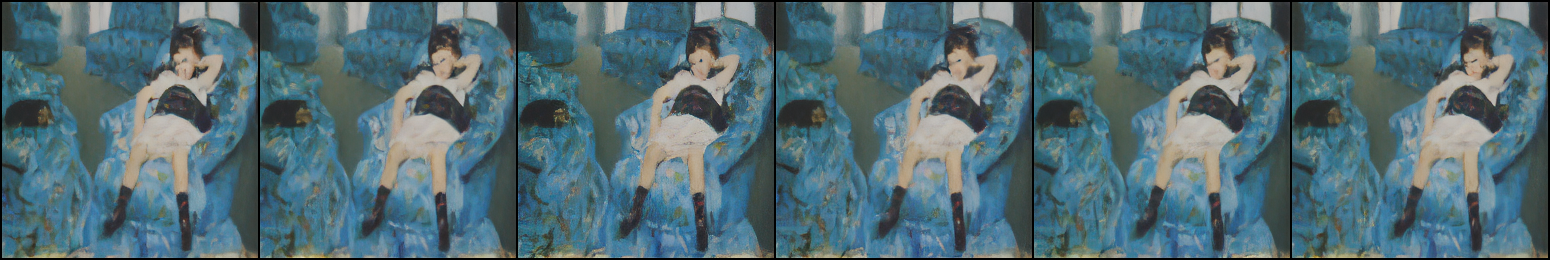

In [7]:
i = 10

images_indexes = [i]
n_samples_per_image = 6

ddim_steps = 20
ddim_eta = 1.0
scale = 1# for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        """ uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.zeros(n_samples_per_image, 3, 64, 64).cuda().to(model.device)}
            ) """
        
        uc = model.get_learned_conditioning(
            torch.zeros(n_samples_per_image, 3, 4, 256, 256).cuda().to(model.device)
            )

        for image_index in images_indexes:
            print(f"rendering {n_samples_per_image} examples of images '{dataset[image_index]['name']}' in {ddim_steps} steps and using s={scale:.2f}.")
            
            if cond_key == 'LR_image':
                xc = rearrange(torch.tensor(dataset[image_index]['LR_image']), 'h w c -> c h w').unsqueeze(0).repeat(n_samples_per_image, 1, 1, 1)
            elif cond_key == 'label':
                xc = rearrange(torch.tensor(dataset[image_index][cond_key]), 's h w c -> c s h w').unsqueeze(0).repeat(n_samples_per_image, 1, 1, 1, 1)
            else:
                raise ValueError(f"Unknown cond_key '{cond_key}'")

            c = model.get_learned_conditioning(xc.to(model.device))

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_image,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)
 

# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_image)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [8]:
def plot_image(data, predict=None):
    """ For a single data point, plot the ground truth image, the input images and the predicted image
    Args:
        gt (torch.tensor): ground truth image
        input (torch.tensor): input images
        predict (torch.tensor): predicted image
    """
    gt, input = data['data'], data['label']
    
    label_images = data['label'].shape[0]
    
    fig, axes = plt.subplots(2, 6, figsize=(20, 10))

    axes[0, 0].imshow(gt)
    axes[0, 0].set_title("Ground truth")
    
    for i in range(label_images):
        axes[i//5, i%5 + 1].imshow(input[i])
        axes[i//5, i%5 + 1].set_title("Input " + str(i+1))
        
    if predict is not None:
        axes[1, 0].imshow(predict)
        axes[1, 0].set_title("Predicted")
        
    plt.show()

In [9]:
def prepare_for_plot(data, all_samples=None):
    
    data_prepared = dict()
    for key, value in data.items():
        if key in ['data', 'label']:
            data_prepared[key] = (value + 1) / 2
    
    predict_prepared = rearrange(all_samples[0][0], 'c h w -> h w c')
    #predict_prepared = (predict_prepared + 1) / 2
    predict_prepared = predict_prepared.cpu().detach().numpy()
    
    return data_prepared, predict_prepared

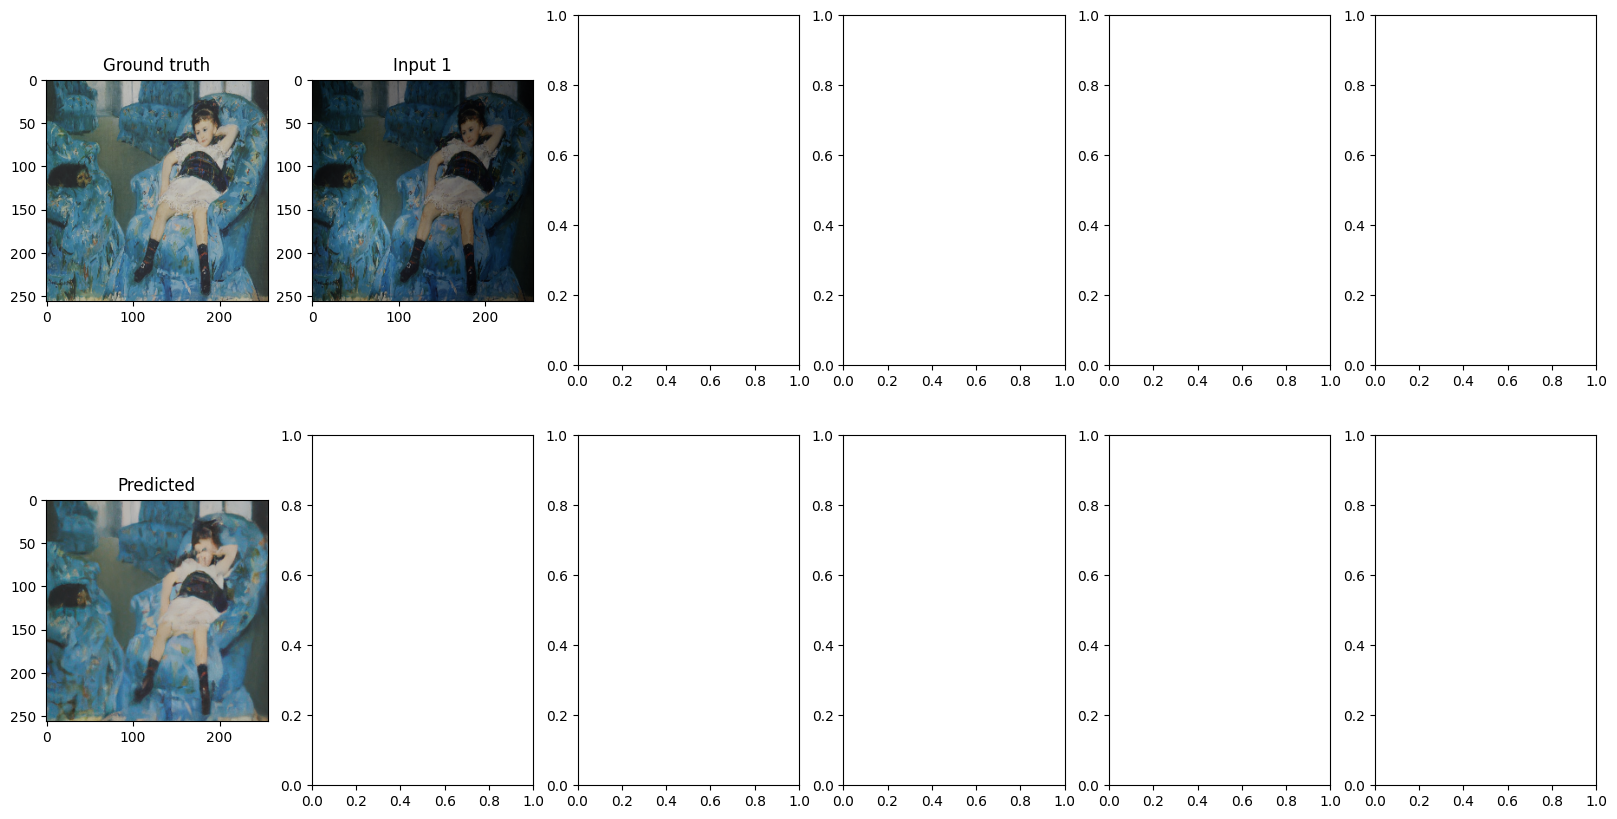

In [10]:
plot_image(*prepare_for_plot(dataset[i], all_samples))

In [11]:
# STUDY OF THE LATENT SPACE

""" cond = c[0]

# convert cond in 0, 1
cond = (cond - cond.min()) / (cond.max() - cond.min())
cond = rearrange(cond, 'c h w -> h w c')
cond = cond.detach().cpu().numpy()

cond_decode = model.decode_first_stage(c[0].unsqueeze(0))

cond_decode = torch.clamp((cond_decode+1.0)/2.0,
                                        min=0.0, max=1.0)
cond_decode = rearrange(cond_decode.squeeze(), 'c h w -> h w c')
cond_decode = cond_decode.detach().cpu().numpy()


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(cond)
axes[0].set_title("Cond in latent space")

axes[1].imshow(cond_decode)
axes[1].set_title("Cond in pixel space") """

' cond = c[0]\n\n# convert cond in 0, 1\ncond = (cond - cond.min()) / (cond.max() - cond.min())\ncond = rearrange(cond, \'c h w -> h w c\')\ncond = cond.detach().cpu().numpy()\n\ncond_decode = model.decode_first_stage(c[0].unsqueeze(0))\n\ncond_decode = torch.clamp((cond_decode+1.0)/2.0,\n                                        min=0.0, max=1.0)\ncond_decode = rearrange(cond_decode.squeeze(), \'c h w -> h w c\')\ncond_decode = cond_decode.detach().cpu().numpy()\n\n\nfig, axes = plt.subplots(1, 2, figsize=(20, 10))\n\naxes[0].imshow(cond)\naxes[0].set_title("Cond in latent space")\n\naxes[1].imshow(cond_decode)\naxes[1].set_title("Cond in pixel space") '

In [12]:
from benchmark import Benchmark

class BenchmarkLDM(Benchmark):
    
    def __init__(self, model, dataloader, mse=True, clip=False, lpips=False, cond_key='label'):
        super().__init__(model, dataloader, mse, clip, lpips, cond_key)
    
    def sample(self, data, ddim_steps=20, ddim_eta=1.0, scale=1):
        """ Method used to sample from the model with the data as conditionning 
            Args:
                data (torch.tensor): conditionning data. size: (batch_size, 3, W, H) or (batch_size, 10, 3, W, H)
            Output:
                torch.tensor: restored image. size: (batch_size, 3, W, H)
        """

        uc = self.model.get_learned_conditioning(
            torch.zeros(data.shape[0], 3, 4, 256, 256).cuda().to(self.model.device)
            )
        
        if self.cond_key == 'LR_image':
            xc = rearrange(torch.tensor(data), 'b h w c -> b c h w')
        elif self.cond_key == 'label':
            xc = rearrange(torch.tensor(data), 'b s h w c -> b c s h w')
        else:
            raise ValueError(f"Unknown cond_key '{cond_key}'")

        c = self.model.get_learned_conditioning(xc.to(self.model.device))

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=data.shape[0],
                                            shape=[3, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=scale,
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)

        x_samples_ddim = self.model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                        min=0.0, max=1.0)
    
        return x_samples_ddim
    

cuda:0


c:\users\shadow\documents\imseqcond\latent-diffusion\src\clip\clip\clip.py:24: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [13]:
benchmark = BenchmarkLDM(model, dataloader, mse=True, clip=True, lpips=True, cond_key=cond_key)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\Users\Shadow\anaconda3\envs\ldm\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [14]:
results = benchmark.evaluate()

Evaluating model on metrics mse, clip, lpips


  0%|          | 0/361 [00:00<?, ?it/s]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0


c:\Users\Shadow\Documents\ImSeqCond\latent-diffusion\scripts\benchmark.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  im = torch.tensor(data['data']).permute(0, 3, 1, 2).to(device)
C:\Users\Shadow\AppData\Local\Temp\ipykernel_7300\1528962894.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xc = rearrange(torch.tensor(data), 'b h w c -> b c h w')


Running DDIM Sampling with 20 timesteps


  0%|          | 1/361 [00:03<21:20,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  1%|          | 2/361 [00:07<21:12,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  1%|          | 3/361 [00:10<21:08,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  1%|          | 4/361 [00:14<20:54,  3.52s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  1%|▏         | 5/361 [00:17<20:48,  3.51s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 6/361 [00:21<20:44,  3.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 7/361 [00:24<20:40,  3.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 8/361 [00:28<20:33,  3.49s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 9/361 [00:31<20:27,  3.49s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 10/361 [00:35<20:21,  3.48s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 11/361 [00:38<20:23,  3.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 12/361 [00:42<20:27,  3.52s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  4%|▎         | 13/361 [00:45<20:26,  3.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 14/361 [00:49<20:24,  3.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 15/361 [00:52<20:25,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 16/361 [00:56<20:25,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  5%|▍         | 17/361 [00:59<20:23,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  5%|▍         | 18/361 [01:03<20:17,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  5%|▌         | 19/361 [01:07<20:24,  3.58s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 20/361 [01:10<20:17,  3.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 21/361 [01:14<20:13,  3.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 22/361 [01:17<20:06,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  6%|▋         | 23/361 [01:21<20:04,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 24/361 [01:24<19:57,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 25/361 [01:28<19:54,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 26/361 [01:31<19:51,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 27/361 [01:35<19:45,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 28/361 [01:39<19:41,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 29/361 [01:42<19:35,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 30/361 [01:46<19:33,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  9%|▊         | 31/361 [01:49<19:30,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 32/361 [01:53<19:24,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 33/361 [01:56<19:20,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 34/361 [02:00<19:15,  3.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 10%|▉         | 35/361 [02:03<19:11,  3.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 10%|▉         | 36/361 [02:07<19:07,  3.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 10%|█         | 37/361 [02:10<19:04,  3.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 38/361 [02:14<19:04,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 39/361 [02:17<19:00,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 40/361 [02:21<18:58,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 11%|█▏        | 41/361 [02:25<18:55,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 42/361 [02:28<18:51,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 43/361 [02:32<18:46,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 44/361 [02:35<18:43,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 45/361 [02:39<18:38,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 46/361 [02:42<18:34,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 47/361 [02:46<18:32,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 48/361 [02:49<18:28,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 14%|█▎        | 49/361 [02:53<18:24,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 50/361 [02:56<18:22,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 51/361 [03:00<18:18,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 52/361 [03:03<18:13,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 15%|█▍        | 53/361 [03:07<18:11,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 15%|█▍        | 54/361 [03:11<18:09,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 15%|█▌        | 55/361 [03:14<18:07,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 56/361 [03:18<18:01,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 57/361 [03:21<17:56,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 58/361 [03:25<17:55,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 16%|█▋        | 59/361 [03:28<17:50,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 60/361 [03:32<17:47,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 61/361 [03:35<17:42,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 62/361 [03:39<17:37,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 63/361 [03:43<17:36,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 64/361 [03:46<17:33,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 65/361 [03:50<17:29,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 66/361 [03:53<17:28,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 19%|█▊        | 67/361 [03:57<17:24,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 68/361 [04:00<17:19,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 69/361 [04:04<17:16,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 70/361 [04:07<17:11,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 20%|█▉        | 71/361 [04:11<17:09,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 20%|█▉        | 72/361 [04:14<17:06,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 20%|██        | 73/361 [04:18<17:03,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 20%|██        | 74/361 [04:22<16:59,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 21%|██        | 75/361 [04:25<16:57,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 21%|██        | 76/361 [04:29<16:51,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 21%|██▏       | 77/361 [04:32<16:47,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 78/361 [04:36<16:42,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 79/361 [04:39<16:39,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 80/361 [04:43<16:36,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 81/361 [04:46<16:33,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 82/361 [04:50<16:31,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 83/361 [04:54<16:28,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 84/361 [04:57<16:24,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 24%|██▎       | 85/361 [05:01<16:22,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 86/361 [05:04<16:19,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 87/361 [05:08<16:15,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 88/361 [05:11<16:10,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 25%|██▍       | 89/361 [05:15<16:07,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 25%|██▍       | 90/361 [05:18<16:04,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 25%|██▌       | 91/361 [05:22<15:58,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 25%|██▌       | 92/361 [05:26<15:55,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 26%|██▌       | 93/361 [05:29<15:51,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 26%|██▌       | 94/361 [05:33<15:49,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 26%|██▋       | 95/361 [05:36<15:45,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 96/361 [05:40<15:40,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 97/361 [05:43<15:36,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 98/361 [05:47<15:34,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 99/361 [05:50<15:31,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 100/361 [05:54<15:26,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 101/361 [05:57<15:22,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 102/361 [06:01<15:19,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 29%|██▊       | 103/361 [06:05<15:16,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 104/361 [06:08<15:13,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 105/361 [06:12<15:08,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 106/361 [06:15<15:05,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 30%|██▉       | 107/361 [06:19<15:00,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 30%|██▉       | 108/361 [06:22<14:56,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 30%|███       | 109/361 [06:26<14:53,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 30%|███       | 110/361 [06:29<14:49,  3.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 31%|███       | 111/361 [06:33<14:47,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 31%|███       | 112/361 [06:37<14:47,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 31%|███▏      | 113/361 [06:40<14:42,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 114/361 [06:44<14:39,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 115/361 [06:47<14:36,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 116/361 [06:51<14:33,  3.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 117/361 [06:54<14:28,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 118/361 [06:58<14:22,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 119/361 [07:01<14:18,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 120/361 [07:05<14:14,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 34%|███▎      | 121/361 [07:09<14:11,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 122/361 [07:12<14:09,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 123/361 [07:16<14:07,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 124/361 [07:19<14:01,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 35%|███▍      | 125/361 [07:23<13:58,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 35%|███▍      | 126/361 [07:26<13:54,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 35%|███▌      | 127/361 [07:30<13:50,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 35%|███▌      | 128/361 [07:33<13:47,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 36%|███▌      | 129/361 [07:37<13:44,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 36%|███▌      | 130/361 [07:41<13:40,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 36%|███▋      | 131/361 [07:44<13:37,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 132/361 [07:48<13:33,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 133/361 [07:51<13:30,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 134/361 [07:55<13:25,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 135/361 [07:58<13:22,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 136/361 [08:02<13:19,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 137/361 [08:05<13:15,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 138/361 [08:09<13:11,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 39%|███▊      | 139/361 [08:12<13:08,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 140/361 [08:16<13:04,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 141/361 [08:20<13:01,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 142/361 [08:23<12:57,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 40%|███▉      | 143/361 [08:27<12:53,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 40%|███▉      | 144/361 [08:30<12:50,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 40%|████      | 145/361 [08:34<12:46,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 40%|████      | 146/361 [08:37<12:42,  3.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 41%|████      | 147/361 [08:41<12:40,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 41%|████      | 148/361 [08:45<12:42,  3.58s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 41%|████▏     | 149/361 [08:48<12:43,  3.60s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 150/361 [08:52<12:41,  3.61s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 151/361 [08:55<12:35,  3.60s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 152/361 [08:59<12:34,  3.61s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 153/361 [09:03<12:28,  3.60s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 154/361 [09:06<12:23,  3.59s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 155/361 [09:10<12:17,  3.58s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 156/361 [09:13<12:12,  3.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 157/361 [09:17<12:08,  3.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 158/361 [09:20<12:03,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 159/361 [09:24<11:59,  3.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 160/361 [09:28<11:56,  3.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


In [ ]:
print(benchmark.results)

import json

print(json.dumps(benchmark.results, indent=4))

In [ ]:
def rescale(data):
    """ Rescale data between 0 and 1 from -1 and 1
        Args:
            data (torch.tensor): data to rescale
        Output:
            torch.tensor: rescaled data
    """
    return {
        'data': (data['data'] + 1) / 2,
        'label': (data['label'] + 1) / 2,
        'name': data['name'],
    }

In [ ]:
# GENERATE SAMPLES

from PIL import Image
import numpy as np

output_folder = os.path.join(model_folder, 'test_predictions_random')

print(output_folder)

for i in range(min(40, len(dataset))):
    
    j = np.random.randint(len(dataset))
    data = dataset[j]
    
    y = data[cond_key]

    predict = benchmark.sample(y[None,...],20)
    #predict = model.predict(y.unsqueeze(0).to(device))
    out = predict.detach().cpu()
    
    out = out[0].transpose(0,1).transpose(1,2)
    
    if os.path.exists(output_folder) == False:
        os.makedirs(output_folder)
        
    # rescale data
    data = rescale(data) # scale between 0 and 1
    
    plot_image(data, out)
    
    out_im = (out.numpy()* 255).astype(np.uint8) # rescale to 0-255
    
    im_pil = Image.fromarray(out_im)
    im_pil.save(os.path.join(output_folder, f'{data["name"]}.png'))